In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)


csv_path = Path("..") / "data" / "processed" / "seagate_features.csv"

df = pd.read_csv(csv_path, parse_dates=['date'])


X_raw = df[['LogReturn', 'CumReturn', 'Volatility_5']].values
y = df['price'].values


mask = ~np.isnan(X_raw).any(axis=1)
X_raw = X_raw[mask]
y = y[mask]


def mean_impute(X: np.ndarray) -> np.ndarray:
    """Column-wise mean imputation"""
    X_out = X.copy()
    col_means = np.nanmean(X_out, axis=0)
    inds = np.where(np.isnan(X_out))
    X_out[inds] = np.take(col_means, inds[1])
    return X_out

def median_impute(X: np.ndarray) -> np.ndarray:
    """Column-wise median imputation"""
    X_out = X.copy()
    col_medians = np.nanmedian(X_out, axis=0)
    inds = np.where(np.isnan(X_out))
    X_out[inds] = np.take(col_medians, inds[1])
    return X_out

class SimpleLinReg:
    """Multivariate Linear Regression with Normal Equation"""
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X]  # add intercept
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), beta[1:]
        return self
    def predict(self, X):
        return self.intercept_ + X @ self.coef_

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)

def pred_fn(model, X):
    return model.predict(X)


X_base = mean_impute(X_raw)
model = fit_fn(X_base, y)
y_hat = model.predict(X_base)

base_mae = mae(y, y_hat)
base_mae


4.443460986575762

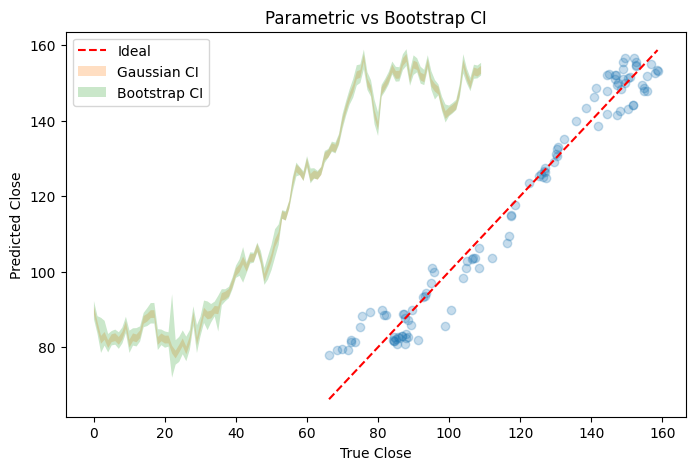

In [ ]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)

# Gaussian CI
gauss_lo = y_hat - 1.96*se_mean
gauss_hi = y_hat + 1.96*se_mean

# Bootstrap CI
def bootstrap_predictions(X, y, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b], y[b])
        preds.append(m.predict(X))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, n_boot=600)

plt.figure()
plt.scatter(y, y_hat, alpha=0.25)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Ideal")
plt.fill_between(np.arange(len(y)), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(np.arange(len(y)), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.xlabel("True Close"); plt.ylabel("Predicted Close")
plt.show()


In [ ]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda X: X[~np.isnan(X).any(axis=1)] if np.isnan(X).any() else X
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw).any(axis=1)
        Xs, ys = X_raw[mask], y[mask]
    else:
        Xs, ys = fn(X_raw), y
    m = fit_fn(Xs, ys)
    yh = m.predict(Xs)
    results.append({'scenario': name, 'mae': mae(ys, yh), 'coeffs': m.coef_, 'intercept': m.intercept_})

sens = pd.DataFrame(results)
sens


,scenario,mae,coeffs,intercept
0,mean_impute,4.443461,"[11.76504469383326, 106.55189563951595, -464.0...",92.10574
1,median_impute,4.443461,"[11.76504469383326, 106.55189563951595, -464.0...",92.10574
2,drop_missing,4.443461,"[11.76504469383326, 106.55189563951595, -464.0...",92.10574


In [ ]:
df2 = df.iloc[mask].copy()
df2['y_hat'] = y_hat
df2['resid'] = df2['price'] - df2['y_hat']

if 'segment' in df2.columns:
    g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
    print(g)

    plt.figure()
    grouped = df2.groupby('segment')['resid']
    data = [s.values for _, s in grouped]
    labels = list(grouped.groups.keys())
    plt.boxplot(data, tick_labels=labels)
    plt.title('Residuals by Segment')
    plt.show()


In [ ]:
bm = bootstrap_metric(y, y_hat, mae, n_boot=600)
bm


{'mean': 4.452896030723131, 'lo': 3.837595673824695, 'hi': 5.07084669312929}